# Importing modules

In [1]:
import matplotlib.pyplot as plt
import seaborn as sbn

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
from skfuzzy.cluster import cmeans_predict
from sklearn.metrics.pairwise import cosine_similarity as cos_dist
from kPOD import k_pod

# Fuzzy C means Class

In [2]:
class Pas_comme_ca_zinedine(ValueError, AttributeError):
    pass

class FCmeans():
    #Constructor
    def __init__(self, n_clusters : int, m : int = 2, error : float = 10**-3, max_iter : int = 10**3, init = "k-means++", seed : int = None):
        self.n_clusters = n_clusters    #Number of cluster
        self.m = m                      #Array exponentiation applied to the membership function u_old at each iteration, where U_new = u_old ** m.
        self.error = error              #Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error
        self.max_iter = max_iter        #Maximum number of iterations allowed.
        self.init = init                #Initial fuzzy c-partitioned matrix. If none provided, algorithm is randomly initialized.
        self.seed = seed                #Sets random seed of init
        self.train = False


    def fit(self, X : np.ndarray):
        km = KMeans(self.n_clusters, max_iter=self.max_iter, random_state=self.seed, init=self.init)
        km.fit(X)
        self.centers = km.cluster_centers_
        self.inertia = km.inertia_
        self.n_iter = km.n_iter_
        self.train = True



    def soft_predict(self, X: np.ndarray) -> np.ndarray:
        if self.train:
            return cmeans_predict(X.T, self.centers, self.m, self.error, self.max_iter, init=None, seed=None)[0].T
        else:
            raise Pas_comme_ca_zinedine("Il faut fit avant ! Eh ouai le bouf...")
                

    def predict(self, X : np.ndarray):
        return self.soft_predict(X).argmax(axis=-1)

In [167]:
class Pas_comme_ca_zinedine(ValueError, AttributeError):
    pass

class FCM_missing():
    #Constructor
    def __init__(self, n_clusters : int, m : int = 2, error : float = 10**-3, max_iter : int = 10**3, init = "k-means++", seed : int = None):
        self.n_clusters = n_clusters    #Number of cluster
        self.m = m                      #Array exponentiation applied to the membership function u_old at each iteration, where U_new = u_old ** m.
        self.error = error              #Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error
        self.max_iter = max_iter        #Maximum number of iterations allowed.
        self.init = init                #Initial fuzzy c-partitioned matrix. If none provided, algorithm is randomly initialized.
        self.seed = seed                #Sets random seed of init
        self.train = False
        self.inertia = 0


    def fit(self, X : pd.DataFrame):
        km = k_pod(X.values, self.n_clusters, self.max_iter)
        self.label = km[0]
        self.centers = np.array(km[1]).reshape(-1, self.n_clusters)
        self.train = True

        self.soft_predict(X)

    def distance_2(self, c, i, X):
        return np.sum(self.h[i,:]*(X.iloc[i,:] - self.centers[:,c])**2)

    def soft_predict(self, data: pd.DataFrame) -> np.ndarray:
        if self.train:
            self.h = (~data.isna().values).astype(int)
            self.u = np.zeros((data.shape[0], self.n_clusters))

            X = data.copy()
            X.fillna(0, inplace=True)

            for c in range(self.n_clusters):
                for i in range(X.shape[0]):
                    self.u[i,c] = 0
                    for l in range(self.n_clusters):
                        self.u[i,c] += (self.distance_2(c, i, X) / self.distance_2(l, i, X))**(1/(self.m - 1))
                    self.u[i,c] = self.u[i,c]**(-1)

                    self.inertia += self.u[i,c]*self.distance_2(c, i, X)
        else:
            raise Pas_comme_ca_zinedine("Il faut fit avant ! Eh ouai le bouf...")
                

    def predict(self, X : np.ndarray):
        return self.soft_predict(X).argmax(axis=-1)

In [148]:
class Ceci_est_un_essaie_rate():
    def __init__(self, n_clusters : int, m : int = 2, error : float = 10**-3, max_iter : int = 10**3):
        self.n_clusters = n_clusters    #Number of cluster
        self.m = m                      #Array exponentiation applied to the membership function u_old at each iteration, where U_new = u_old ** m.
        self.error = error              #Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error
        self.max_iter = max_iter        #Maximum number of iterations allowed.
        self.train = False
        self.inertia = [0]

    #Square distance between center cluster c and i-th observation of X
    def distance_2(self, c, i, X):
        return np.sum(self.h[i,:]*(X.iloc[i,:] - self.centers[c,:])**2)

    def fit(self, data : pd.DataFrame):
        self.train = True
        self.h = (~data.isna().values).astype(int)
        self.u = np.zeros((self.n_clusters, data.shape[0]))
        self.centers = np.random.random((self.n_clusters, data.shape[1]))

        X = data.copy()
        X.fillna(0, inplace=True)
        convergence_criterion = False

        t = 0
        while (t < self.max_iter and not convergence_criterion):
            self.L = 0
            for c in range(self.n_clusters):
                for i in range(X.shape[0]):

                    self.u[c,i] = 0
                    for l in range(self.n_clusters):
                        self.u[c,i] += (self.distance_2(c, i, X) / self.distance_2(l, i, X))**(1/(self.m - 1))
                    self.u[c,i] = self.u[c,i]**(-1)

                    self.L += self.u[c,i]*self.distance_2(c, i, X)

            for c in range(self.n_clusters):
                for j in range(X.shape[1]):
                    num = np.sum(self.u[c,:]*self.h[:,j]*X.iloc[:,j].values)
                    den = np.sum(self.u[c,:]*self.h[:,j])
                    self.centers[c,j] = num/den

            self.inertia.append(self.L)
            if len(self.inertia) > 1:
                convergence = np.abs(self.inertia[-2] - self.L)
                print(convergence)

                if convergence <= self.error:
                    convergence_criterion = True
            
            t += 1

        self.n_iter = t

# 2 - Get all files needed

In [6]:
data_folder = "../../Dataset/Movie/"

In [117]:
rating = pd.read_csv(f"{data_folder}ratings.csv").drop(["timestamp"], axis=1)
movie = pd.read_csv(f"{data_folder}movies.csv")

data = pd.merge(movie, rating, on="movieId").drop(["genres", "movieId"], axis=1)
data.shape

(25000095, 3)

# 3 - Transforming data

In [118]:
#On garde les NB_FILM films les plus notés
NB_FILM = 500
keep_title = data["title"].value_counts().sort_values(ascending=False)[:NB_FILM].index
data_title = data[data["title"].isin(keep_title)]
data_title.shape

(10944751, 3)

In [119]:
#On garde les users qui ont données une note sur au moins THRESH_USER % des films
THRESH_USER = 0.40
keep_user = data_title["userId"].value_counts()/NB_FILM >= THRESH_USER
data_title_user = data_title[data_title["userId"].isin(keep_user[keep_user].index)]

In [120]:
#On fait notre pivot table
user_title_df = data_title_user.pivot_table(index="userId", columns="title", values="rating")
user_title_df.to_csv(f"{data_folder}test_for_users.csv")
user_title_df.shape

(10103, 500)

In [64]:
user_title_df = pd.read_csv(f"{data_folder}test_for_users.csv", index_col=0).iloc[:250, :]

In [168]:
fcm_m = FCM_missing(3)
fcm_m.fit(user_title_df)
fcm_m.centers

array([[3.57583581, 3.41631397, 4.00989688],
       [3.94090707, 3.73097397, 3.42184168],
       [3.49065564, 3.31395166, 3.65336853],
       ...,
       [3.58686389, 2.77171597, 2.77171597],
       [3.58686389, 0.75      , 1.27171597],
       [3.58686389, 2.39671597, 1.27171597]])

In [146]:
fcm = Ceci_est_un_essaie_rate(3, max_iter=100)
fcm.fit(user_title_df)

(3, 500)
94115.81540680822
39877.49651689779
721.41245645038
24.125640513797407
2.926050346788543
0.37543376726534916
0.04857260864082491
0.006296337443927769
0.0008166299157892354


In [147]:
fcm.centers

array([[3.48489222, 3.29415719, 4.28023347, ..., 2.97227756, 3.77319756,
        3.65667312],
       [3.48483084, 3.2941017 , 4.28021425, ..., 2.9721999 , 3.77312821,
        3.6566077 ],
       [3.4848224 , 3.29409405, 4.28021162, ..., 2.9721892 , 3.77311867,
        3.6565987 ]])

In [126]:
fcm.u

array([[0.33333342, 0.33331529, 0.33333477, 0.33334058, 0.33335711,
        0.33336352, 0.33331857, 0.3333619 , 0.33334672, 0.33330869,
        0.33333832, 0.33330936, 0.3333372 , 0.33332444, 0.33331443,
        0.33332093, 0.33331492, 0.33332921, 0.33333666, 0.33332312,
        0.33335439, 0.33333873, 0.33333147, 0.33336033, 0.33336455,
        0.33336231, 0.33335248, 0.33334775, 0.33335474, 0.33334239,
        0.33331923, 0.33335092, 0.33333681, 0.33332332, 0.33333197,
        0.3333302 , 0.33333811, 0.33332047, 0.33333461, 0.3333105 ,
        0.33331699, 0.33333446, 0.33332662, 0.33336072, 0.33331731,
        0.33335299, 0.3333288 , 0.33331837, 0.33335652, 0.33335204,
        0.3333244 , 0.33335731, 0.33335587, 0.33334065, 0.33331437,
        0.33331195, 0.3333362 , 0.33332407, 0.33334596, 0.33334328,
        0.33330889, 0.33335035, 0.33333247, 0.3333298 , 0.33332514,
        0.33336756, 0.3333311 , 0.33333002, 0.33335904, 0.33334421,
        0.33335481, 0.33332826, 0.33332153, 0.33

# Mis en forme des données

In [5]:
def normalization_min_max(row):
    return (row - row.mean())/(row.max() - row.min())

In [6]:
def cosine_similarity(X):
    return (cos_dist(X)+1)/2

In [7]:
for_users_data = user_title_df.fillna(0).apply(normalization_min_max, axis=1)
for_movies_data = user_title_df.fillna(0).apply(normalization_min_max, axis=0)

In [8]:
#Création de la matrice de cosinus distance
all_users = user_title_df.index
cos = cosine_similarity(for_users_data)
similarity_users = pd.DataFrame(cos, index=all_users, columns=all_users)
np.fill_diagonal(similarity_users.values, 0)


#Création de la matrice de cosinus distance
all_movies = user_title_df.columns
cos = cosine_similarity(for_movies_data.T)
similarity_movies= pd.DataFrame(cos, index=all_movies, columns=all_movies)
np.fill_diagonal(similarity_movies.values, 0)


del(cos)

# Guess Algo

In [9]:
#On devine la note en fonction des candidtats similaires
def guess_rate(user, title, N, similarity_users):
    all_similar_users = similarity_users.loc[user].sort_values(ascending=False).index
    user_title_mat = for_users_data
    
    rate = 0
    weight = 0
    k = 0
    i = 0

    while (k < N):
        similar_user = all_similar_users[i]
        r = user_title_mat.loc[similar_user, title]

        if not (pd.isnull(r)):
            w = similarity_users.loc[similar_user, user]
            rate += w*r
            weight += w
            k += 1

        i += 1

    return rate/weight

In [10]:
def get_similar_movies_from_users(user_id, N, similarity_users):
    all_rates = []
    keep_movies = []

    for movie in tqdm(user_title_df.columns):
        if (pd.isnull(user_title_df.loc[user_id, movie])):
            all_rates.append(guess_rate(user_id, movie, N, similarity_users))
            keep_movies.append(movie)

    return pd.Series(all_rates, keep_movies).sort_values(ascending=False)

In [11]:
def get_similar_movies_from_movies(user_id, similarity_movies):
    similar_movies = []

    movies_rates = user_title_df.loc[user_id].dropna()
    movies = movies_rates.index
    rates = movies_rates.values
    user = [(movies[i], rates[i]) for i in range(len(rates))]

    for movie, rate in tqdm(user):
        movie_list = (similarity_movies.loc[:, movie]*(rate-2.5)).sort_values(ascending=False)
        similar_movies.append(movie_list)

    similar_movies = pd.concat(similar_movies, axis=1)
    similar_movies = similar_movies.drop([movie for movie, rate in user], axis=0)
    return similar_movies.sum(axis=1).sort_values(ascending=False)

In [12]:
def recommanded_movies(user_id, similarity_users, similarity_movies):
    get_users = get_similar_movies_from_users(user_id, 500, similarity_users)
    get_movies = get_similar_movies_from_movies(user_id, similarity_movies)

    arg_movies = []
    for title in get_users.index:
        arg_movies.append(int(np.argwhere(get_movies.index == title)))

    recommanded = pd.DataFrame(index=get_users.index, columns=["Arg Users", "Arg Movies"], data=np.array([range(len(arg_movies)), arg_movies]).T)
    recommanded["Mean"] = recommanded.mean(axis=1)

    return recommanded.sort_values(by="Mean")

# Find K

In [15]:
N = 10
K_RANGE = range(2, N+1)
all_inertia = {"Users" : [], "Movies" : []}
data = {"Users" : user_title_df.values, "Movies" : user_title_df.T.values}

for key in all_inertia.keys():
    for k in tqdm(K_RANGE):
        fcm = FCmeans(k)
        fcm.fit(data[key])
        all_inertia[key].append(fcm.inertia)

  0%|          | 0/9 [00:00<?, ?it/s]

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

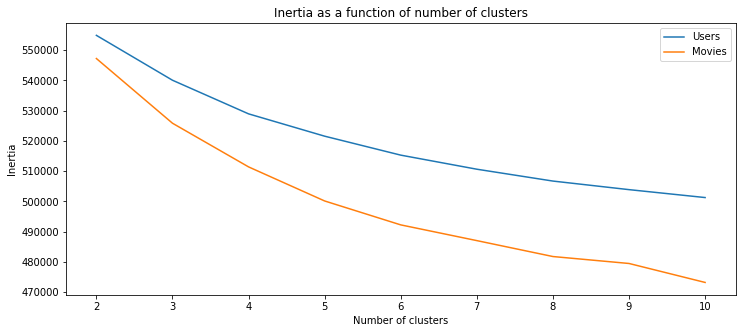

In [14]:
plt.figure(figsize=(12,5))

i = 0
for key in all_inertia.keys():
    plt.plot(K_RANGE, all_inertia[key], label=key)

plt.xticks(K_RANGE)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

plt.title("Inertia as a function of number of clusters")
plt.legend()

plt.savefig("img/find_K_own.jpg", dpi=250)
plt.show()

# 1er méthode : similarité entre les appartenance aux clusters

In [120]:
fcm = FCmeans(4)
fcm.fit(for_users_data.values)
soft_pred = fcm.soft_predict(for_users_data.values)

In [121]:
users = for_users_data.index
membership_users = pd.DataFrame(index=users, columns=[f"% Cluster {i+1}" for i in range(soft_pred.shape[1])])
membership_users.iloc[:, :] = soft_pred
membership_users["Final Cluster"] = membership_users.loc[:,:].values.argmax(axis=-1) + 1

membership_users

,% Cluster 1,% Cluster 2,% Cluster 3,% Cluster 4,Final Cluster
userId,,,,,
1,0.350748,0.238488,0.243582,0.167182,1
2,0.337602,0.234296,0.250126,0.177976,1
12,0.20388,0.263762,0.259621,0.272737,4
31,0.219915,0.287361,0.264305,0.228419,2
43,0.21171,0.308798,0.242651,0.23684,2
...,...,...,...,...,...
162512,0.274711,0.278178,0.238456,0.208656,2
162516,0.259274,0.222936,0.353056,0.164733,3
162519,0.183916,0.247833,0.238746,0.329505,4


In [122]:
fcm = FCmeans(3)
fcm.fit(for_movies_data.T.values)
soft_pred = fcm.soft_predict(for_movies_data.T.values)

In [123]:
movies = for_movies_data.columns
membership_movies = pd.DataFrame(index=movies, columns=[f"% Cluster {i+1}" for i in range(soft_pred.shape[1])])
membership_movies.iloc[:, :] = soft_pred
membership_movies["Final Cluster"] = membership_movies.loc[:,:].values.argmax(axis=-1) + 1

membership_movies

,% Cluster 1,% Cluster 2,% Cluster 3,Final Cluster
(500) Days of Summer (2009),0.257775,0.273912,0.468312,3
10 Things I Hate About You (1999),0.289879,0.398735,0.311386,2
12 Angry Men (1957),0.379814,0.306414,0.313773,1
2001: A Space Odyssey (1968),0.421667,0.30937,0.268963,1
28 Days Later (2002),0.288103,0.308718,0.40318,3
...,...,...,...,...
X-Men (2000),0.268103,0.403177,0.328719,2
X2: X-Men United (2003),0.258965,0.35459,0.386446,3
You've Got Mail (1998),0.306872,0.423834,0.269294,2
Young Frankenstein (1974),0.413412,0.34531,0.241277,1


In [125]:
cos = cosine_similarity(membership_users.iloc[:,:-1])
similarity_users_cluster = pd.DataFrame(cos, index=users, columns=users)
cos = cosine_similarity(membership_movies.iloc[:,:-1])
similarity_movies_cluster = pd.DataFrame(cos, index=movies, columns=movies)
del(cos)

In [139]:
test_cluster = recommanded_movies(12, similarity_users_cluster, similarity_movies_cluster)
test = recommanded_movies(12, similarity_users, similarity_movies)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

In [127]:
np.abs(test_cluster["Mean"].values - test["Mean"].values).mean()

5.088709677419355

In [142]:
test.to_csv("pourLeRapport.csv")

In [128]:
test_cluster = recommanded_movies(1, similarity_users_cluster, similarity_movies_cluster)
test = recommanded_movies(1, similarity_users, similarity_movies)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

In [129]:
print(test_cluster[:10])
print(test[:10])

                              Arg Users  Arg Movies  Mean
Ocean's Eleven (2001)                 5           2   3.5
Fight Club (1999)                     0          10   5.0
Bourne Identity, The (2002)          12           0   6.0
Catch Me If You Can (2002)            9          12  10.5
Minority Report (2002)               21           1  11.0
Beautiful Mind, A (2001)             34           6  20.0
Kill Bill: Vol. 1 (2003)             15          25  20.0
Bourne Supremacy, The (2004)         40           4  22.0
Kill Bill: Vol. 2 (2004)             25          23  24.0
I, Robot (2004)                      26          24  25.0
                                 Arg Users  Arg Movies  Mean
Batman Begins (2005)                     1           0   0.5
Prestige, The (2006)                     5           6   5.5
How to Train Your Dragon (2010)          9           3   6.0
Inglourious Basterds (2009)              6           8   7.0
Toy Story 3 (2010)                      12           2   

In [138]:
test[:10]

,Arg Users,Arg Movies,Mean
Batman Begins (2005),1,0,0.5
"Prestige, The (2006)",5,6,5.5
How to Train Your Dragon (2010),9,3,6.0
Inglourious Basterds (2009),6,8,7.0
Toy Story 3 (2010),12,2,7.0
Star Trek (2009),19,1,10.0
Kung Fu Panda (2008),21,4,12.5
Django Unchained (2012),16,12,14.0
District 9 (2009),23,7,15.0
"I, Robot (2004)",22,9,15.5
